## 1. Импорт Библиотек

In [62]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

pd.options.mode.chained_assignment = None

# этот блок закомментирован так как используется только на kaggle
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# for local
from importlib import reload
print(os.listdir('./Data'))
PATH_to_file = './Data/'

['main_task.csv', 'test.csv', 'train.csv']


In [64]:
import my_utility_metrics as my

In [66]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('27/01/2021')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


## 2. Импорт данных

In [68]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [70]:
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

## 3. Предварительный анализ данных

In [72]:
# выведем сводную информацию по датасету df без теста и теста kaggle
my.describe_without_plots_all_collumns(df[df['Train']==1], short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,client_id,int64,73799,0,73799,1,55138,110147,55274
1,app_date,object,73799,0,120,NaN,NaN,NaN,NaN
2,education,object,73492,307,5,NaN,NaN,NaN,NaN
3,sex,object,73799,0,2,NaN,NaN,NaN,NaN
4,age,int64,73799,0,52,21,39.2806,72,37
5,car,object,73799,0,2,NaN,NaN,NaN,NaN
6,car_type,object,73799,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,73799,0,21,0,0.275749,33,0
8,good_work,int64,73799,0,2,0,0.164894,1,0
9,score_bki,float64,73799,0,69096,-3.62459,-1.90472,0.199773,-1.92082


В тренировочной выборке 73799 клиентов, в тестовой  - 36349. Всего 20 переменных, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 8 числовых. Всего пропусков 307 (0.4%), все пропуски в переменной education. client_id уникальный числовой признак, который не несет информации.

В бинарных признаках наше целевая переменная  default и искуственно добавленный признак тренировочной части датасета Train  

Описания полей датасета
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [74]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (8)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','days']
# client_id не включаем в списки

## 4. Анализ по переменным
---
Начнем с числовых переменных
### 1. age

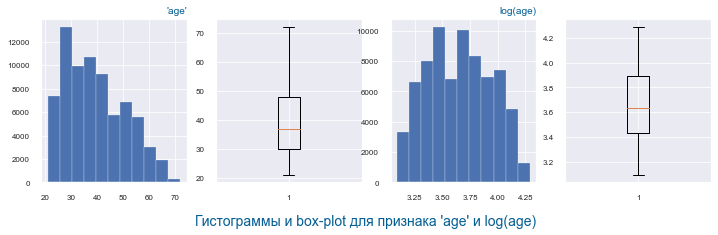

In [76]:
my.four_plot_with_log2('age', df[df['Train']==1])

In [78]:
my.describe_without_plots('age', df[df['Train']==1].age)

,age
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,39.2806
медиана,37
мин,21
макс,72


In [80]:
df['age'] = np.log(df['age'] + 1)

Распределение логнормальное , выбросов по квартилям нет.

### 2. decline_app_cnt

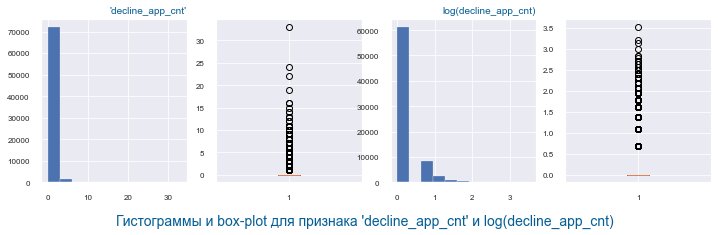

In [82]:
my.four_plot_with_log2('decline_app_cnt', df[df['Train']==1])

In [84]:
# посмотрим на выбросы - границы (оригинал и логарифм) и их кол-во
my.borders_of_outliers('decline_app_cnt',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,0.0,0.0
границы выбросов без логарифма,0.0,0.0
кол-во значений за границей,0.0,12585.0


Выбросов очень много (12585 из 73799 - 17%)

In [86]:
my.describe_without_plots('decline_app_cnt', df[df['Train']==1].decline_app_cnt)

,decline_app_cnt
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,0.275749
медиана,0
мин,0
макс,33


In [88]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

In [89]:
my.borders_of_outliers('decline_app_cnt',df[(df['Train']==1) & (df['decline_app_cnt']!=0)], log = True)

,левая,правая
границы выбросов с логарифмом,0.204558,1.063307
границы выбросов без логарифма,0.226983,1.895933
кол-во значений за границей,0.000000,238.000000


Распределение логнормальное - взяли логарифм, выбросов очень много даже после логарифмирования. , Вероятно в этом критерии два распределения, поэтому удалять не будем и построим модель.

### 3. bki_request_cnt

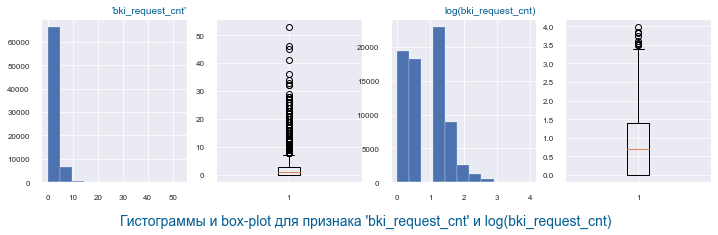

In [90]:
my.four_plot_with_log2('bki_request_cnt', df[(df['Train']==1)])

In [91]:
# визуально выбросов нет, посмотрим на числовые значения границ
my.borders_of_outliers('bki_request_cnt',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,-2.079442,3.465736
границы выбросов без логарифма,-0.875000,31.000000
кол-во значений за границей,0.000000,9.000000


In [92]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

Распределение логнормальное - взяли логарифм, выбросов совсем не много, оставим их.

### 4. income

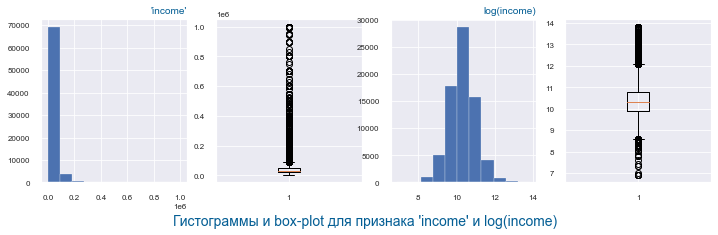

In [93]:
my.four_plot_with_log2('income', df[df['Train']==1])

In [94]:
my.borders_of_outliers('income',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,8.590378,12.092136
границы выбросов без логарифма,5378.647840,178461.983007
кол-во значений за границей,595.000000,1172.000000


In [95]:
df['income'] = np.log(df['income'] + 1)

Распределение логнормальное - взяли логарифм, выбросов очень много и слева и справа даже после логарифмирования, удалять их не будем. Построим модель.  

### 5.score_bki

,score_bki
кол-во строк,73799
тип значений,float64
кол-во значений,73799
кол-во NaN,0
среднее,-1.90472
медиана,-1.92082
мин,-3.62459
макс,0.199773


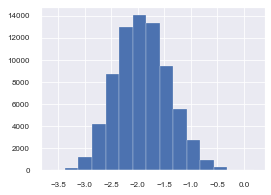

In [96]:
my.describe_with_hist('score_bki', df[df['Train']==1].score_bki)

In [97]:
my.borders_of_outliers('score_bki',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,-3.294088,-0.535277
кол-во значений за границей,52.000000,299.000000


Распределение нормальное. Выбросов не много, не удаляли

### 6.sna

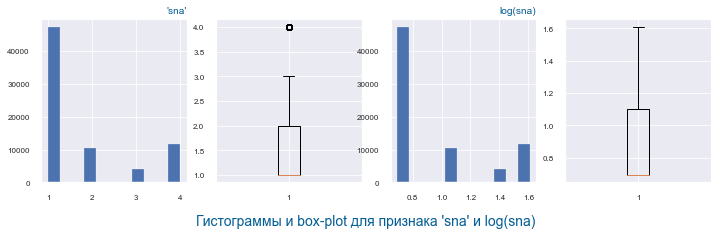

In [98]:
my.four_plot_with_log2('sna', df[df['Train']==1])

In [99]:
my.describe_without_plots('sna', df[df['Train']==1].sna)

,sna
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,1.73333
медиана,1
мин,1
макс,4


Распределение смещено вправо - скорее логнормальное. Всего 4 значения лучше использовать как категориальный признак. Выбросов нет. 

### 7.first_time

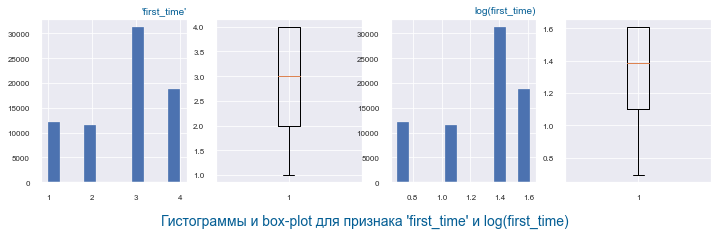

In [100]:
my.four_plot_with_log2('first_time', df[df['Train']==1])

In [101]:
my.describe_without_plots('first_time', df[df['Train']==1].sna)

,first_time
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,1.73333
медиана,1
мин,1
макс,4


Распределение смещено влево - нормальное. Выбросов нет. Так же используем эти 4 значения как категориальный признак.

### 8.region_rating

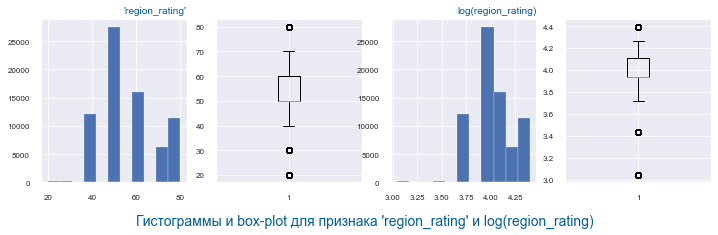

In [102]:
my.four_plot_with_log2('region_rating', df[df['Train']==1])

In [103]:
my.describe_without_plots('region_rating', df[df['Train']==1].region_rating)

,region_rating
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,56.7257
медиана,50
мин,20
макс,80


In [104]:
my.borders_of_outliers('region_rating',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,35.0,75.0
кол-во значений за границей,506.0,11469.0


Распределение скорее логнормальное. Выбросов слева в кол-ве 506 не удаляла.В принципе можно разделить и использовать как категориальный признак.

### 9. education

<AxesSubplot:>

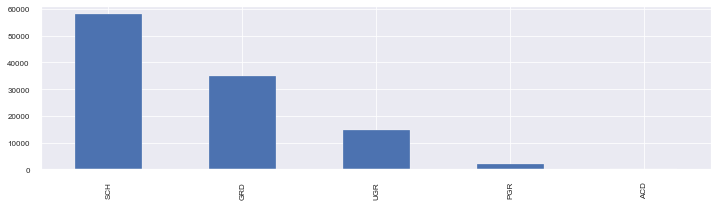

In [105]:
df['education'].value_counts().plot.bar()

In [106]:
# заполним пропуски в education
# переменной education 307 (0.4%) пропущенных значений 
# заполним пропуски самым популярным значением 
df['education'] = df['education'].fillna('SCH')

### 10. app_date 

In [107]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [108]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [109]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

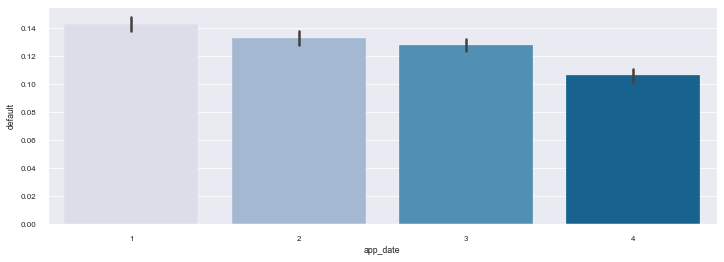

In [110]:
# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default', palette="PuBu");

<AxesSubplot:xlabel='client_id', ylabel='days'>

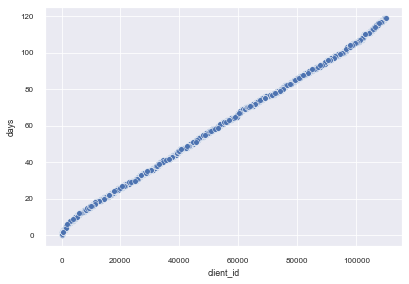

In [111]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=df)

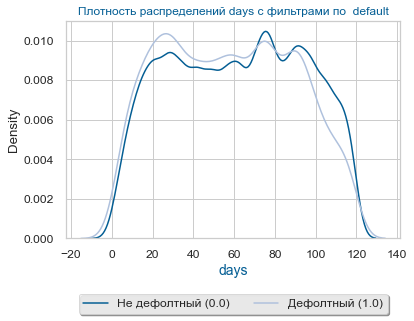

In [112]:
my.plot_filter_df_kde(['Не дефолтный','Дефолтный'], 'default', 'days', df[df['Train']==1], 1.1)

На графике видно, что с 90 дня борьба с дефолтами стала успешной

### Оценка корреляций

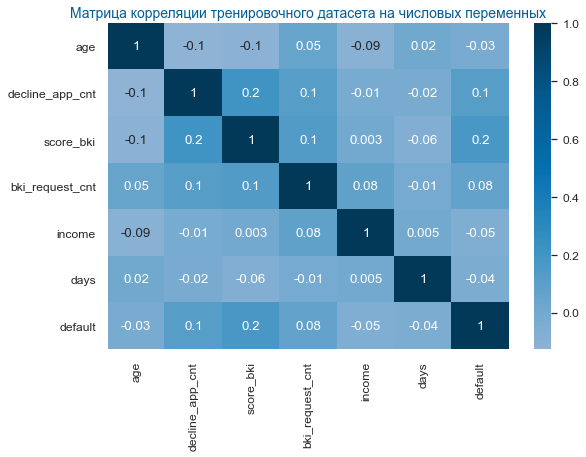

In [113]:
my.simple_heatmap('Матрица корреляции тренировочного датасета на числовых переменных',df[df['Train']==1], num_cols+['default'], 1.1, 1, 9)

Cильно скорелированных между собой признаков нет, все берем в работу

### Значимость непрерывных переменных по ANOVA F test

<AxesSubplot:title={'center':'Значимость непрерывных переменных по ANOVA F test'}>

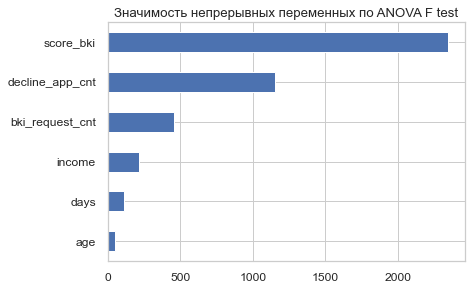

In [114]:
temp_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

Оценка плательщика БКИ (score_bki) самый значимый показатель по ANOVA F test, потом кол-во отказанных заявок (declain_app_cnt) и в конце возраст (age)

### Посмотрим на значимость категориальных и бинарных переменных 

['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_l']


<AxesSubplot:title={'center':'Значимость бин. и категор. переменных по Mutual information test'}>

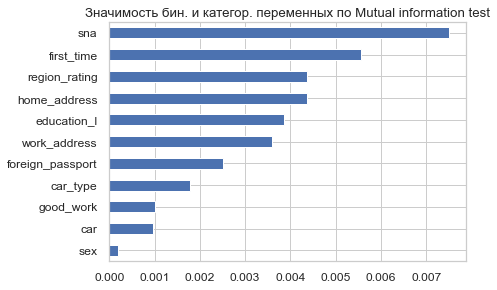

In [115]:
label_encoder = LabelEncoder()
df['education_l'] = label_encoder.fit_transform(df['education'])

# паралельно подготовим бинарные переменные и переведем их в числовой формат
# для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# тут могут быть потенциальные даталики, но мы пока не придумали как это обработать,
# потому что далее по этим меткам формируются новые фичи по get_dummies

all_cat_and_bin_cols = cat_cols+bin_cols
all_cat_and_bin_cols.remove('education')
all_cat_and_bin_cols.append('education_l')
print(all_cat_and_bin_cols)

temp_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

Самым значимым признаком по Тест - Информации является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time), потом идет рейтинг региона (region_rating).

## 5. Подготовка данных к машинному обучению

### Категориальные признаки

In [116]:
# реализуем метод OneHotLabels через get_dummies
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

### Стандартизация

In [117]:
# стандартизацию проводим отдельно для трейна и теста, чтобы не допустить даталиков
my.StandardScaler_df_and_filna_0(df[df['Train']==1], num_cols)

my.StandardScaler_df_and_filna_0(df[df['Train']==0], num_cols)

### Построчная верификация первых двух строк

In [118]:
display(df.head())

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,education_l,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,9.798183,0,0.0,1,31,3,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,9.852247,0,0.0,1,70,3,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,25887,2014-02-01,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,10.308986,1,0.0,1,31,3,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,16222,2014-01-23,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,9.210440,0,0.0,1,22,3,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,101655,2014-04-18,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,10.308986,1,0.0,1,107,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


### Удаление нечисловых критериев

In [119]:
df.drop(['app_date', 'education_l'], axis=1, inplace=True)

## 6. Построение модели

### Разбиваем датасет на тренировочный и тестовый

In [120]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [121]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [122]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

### Обучаем модель, генерируем результат и сравниваем с тестом

In [123]:
# первая модель на автомате
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

### Оценка качества модели

### Качественные метрики

In [124]:
# в первый раз инициируем глобальную переменную с предыдущим скором
my.last_pred = np.zeros((3,len(y_test)))

In [125]:
my.test_last_pred(y_test, y_pred, y_pred_prob) if (my.last_pred[0].max() == 0) else 0
my.all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.875000,0.0,(TP+TN)/(P+N)
balanced accuracy,0.509175,0.0,сбалансированная accuracy
precision,0.411765,0.0,точность = TP/(TP+FP)
recall,0.022989,0.0,полнота = TP/P
f1_score,0.043546,0.0,среднее гармоническое точности и полноты
roc_auc,0.745002,0.0,Area Under Curve - Receiver Operating Characte...


### Матрица ошибок

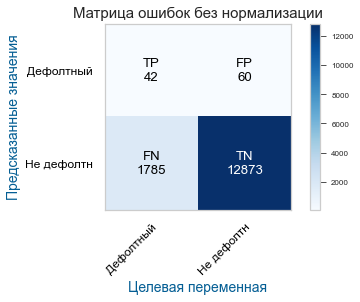

In [126]:
my.confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2, normalize=False)

### ROC кривая

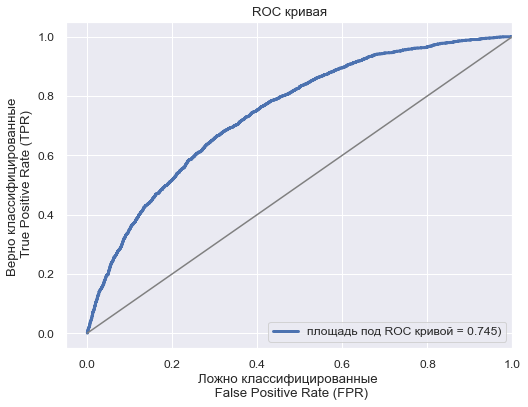

In [127]:
my.ROC_curve_with_area(y_test, y_pred_prob, 1.1)

ROC кривая верно не отразила данные, данные не сбаллансированы (ошибка второго рода, что приведет к  убытку).Сonfusion matrix сигнализирует о том, что что-то не впорядке (f1). Надо посмотреть на метрику, которая может оценивать эффективность алгоритма на несбалансированных данных (PRC-AUC).

### Precision-Recall кривая

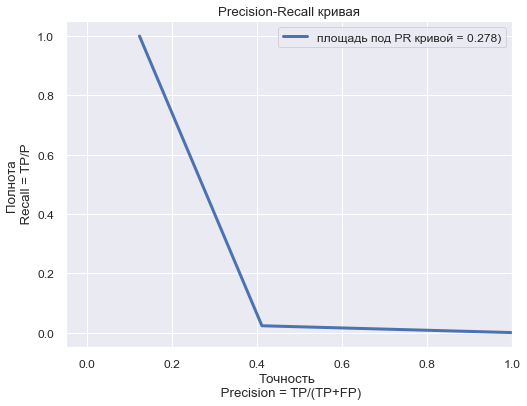

In [128]:
my.PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

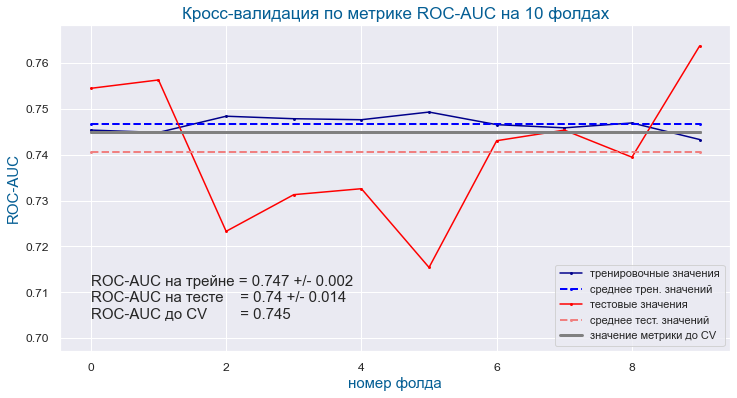

In [129]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
my.vis_cross_val_score('ROC-AUC', temp_vec, 0.744846, 1.1)

Модель, которую мы получили, очень плохая, несмотря на то, что целевая метрика ROC-AUC достаточно высокая (=0.745).  
Потому что:
- Из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (38 из 1789). Об этом также свидетествует метрика полнота recall = 0.020799. Таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка, так как мы будем выдавать кредиты людям, которые их не смогут вернуть. 
- Но целевая переменная площадь под ROC кривой оказалась не такой уж плохой. Дело в том, что эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных, поэтому мы добавили Precision-Recall кривую и увидели, что эффективность нашего алгоритма оставляет желать лучшего.  

Кросс валидация показала дисперсию ошибки на тесте 0.014 и так как мы не использовали перемешивания. В анализе признака data приводилась аналитика, которая говорила о том, что вероятно в середине периода в банке проводилась какая-то акция и порог выдачи кредита снижался.

### Поиск оптимальных параметров модели

In [130]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
print('─' * 10)
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False
──────────
Accuracy: 0.6687
Precision: 0.2256
Recall: 0.6891
F1: 0.3399


Метрика f1 подросла почти в 10 раз. Модель работает эффективнее. Построим модель на этих параметрах и посмотрим, но сначала заново пересоберем трейн и тест перемешав выборку

In [131]:
# вторая модель на параметрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'sag', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

### Оценка качества модели на оптимальных параметрах 

In [132]:
my.test_last_pred(y_test, y_pred, y_pred_prob) if (my.last_pred[0].max() == 0) else 0
my.all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.670528,0.204472,(TP+TN)/(P+N)
balanced accuracy,0.677566,-0.168391,сбалансированная accuracy
precision,0.226289,0.185475,точность = TP/(TP+FP)
recall,0.686918,-0.663930,полнота = TP/P
f1_score,0.340431,-0.296885,среднее гармоническое точности и полноты
roc_auc,0.744223,0.000780,Area Under Curve - Receiver Operating Characte...


все метрики подросли по сравнению с первой моделью, кроме accuracy и precision. Благодая сбалансированной accuracy ошибке второго рода будет лучше чем на первой модели, т.е. новая модель работает лучше.

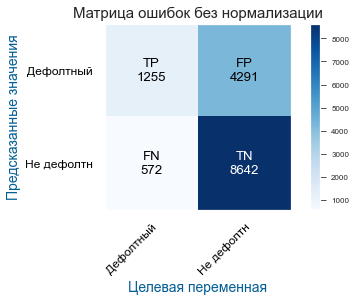

In [133]:
my.confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2, normalize=False)

Ложно дефолтные (FP) попали в позитивно не дефотные (TN).

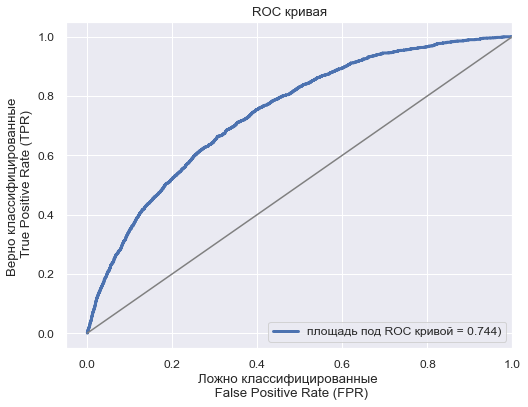

In [134]:
my.ROC_curve_with_area(y_test, y_pred_prob, 1.1)

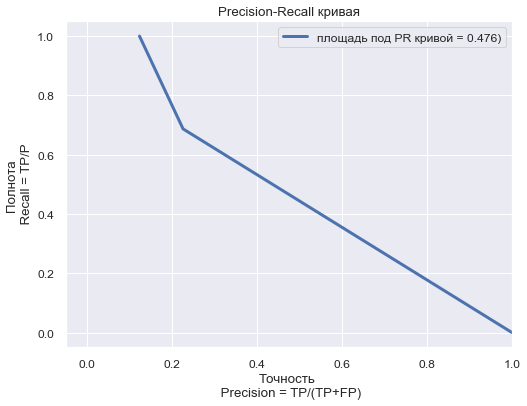

In [135]:
my.PR_curve_with_area(y_test, y_pred, 1.1)

Эффективность алгоритма подросла и теперь более менее хорошо ведет себя на несбалансированных данных. Проверим это с помощью кросс-валидации

### Кросс-валидация

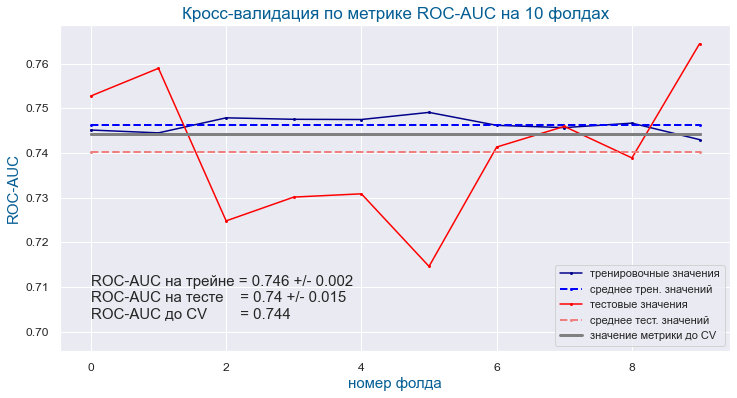

In [136]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
my.vis_cross_val_score('ROC-AUC', temp_vec, 0.744223, 1.1)

Видно что при разбиении на 10 фолдов ROC-AUC меняется не сильно, есть один провал до 0.715. Среднее по фолдам примерно равно предсказанному значению до кроссвалидации 0.744, дисперсия 0.015, поэтому можно улучшить параметры и модель будет работать еще лучше.

### Проверка нулевых коэффициэнтов при регуляризации первого порядка

In [137]:
# регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки,
# которые не нравятся модели (в них могут быть выбросы или неподходящий формат)
# можно это поможет избавиться от большой дисперсии при кросс-валидации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

display(my.model_coef(X_train.columns, model.coef_[0]))

,имя признака,коэффициент модели
0,score_bki,0.972919
1,region_rating_80,-0.752238
2,region_rating_20,0.692997
3,education_SCH,0.678562
4,region_rating_30,0.580224
5,home_address_2,0.530856
6,education_UGR,0.527726
7,region_rating_70,-0.425695
8,decline_app_cnt,0.411110
9,work_address_3,0.407070


Влияние score_bki самое большое, следом идут разные значения рейтинга региона, школьное образование, кол-во отказов.  
Кандидаты на удаление:
- work_address_1
- home_address_1
- sna_3
- region_rating_60
- first_time_3
- education_PGR

In [138]:
# формируем список отсева признаков
drop_list_cols = ['work_address_1', 'home_address_1', 'sna_3', 'region_rating_60', 'first_time_3', 'education_PGR']

In [139]:
#заново формируем выборки для обучения без этих признаков
train_data = df.query('Train == 1').drop(['Train', 'client_id']+drop_list_cols, axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id']+drop_list_cols, axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Проверка качества модели после удаления признаков

In [140]:
# вторая модель на параметрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'sag', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

my.test_last_pred(y_test, y_pred, y_pred_prob) if (my.last_pred[0].max() == 0) else 0
my.all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.670393,0.000136,(TP+TN)/(P+N)
balanced accuracy,0.677253,0.000312,сбалансированная accuracy
precision,0.226109,0.000180,точность = TP/(TP+FP)
recall,0.686371,0.000547,полнота = TP/P
f1_score,0.340160,0.000271,среднее гармоническое точности и полноты
roc_auc,0.744262,-0.000039,Area Under Curve - Receiver Operating Characte...


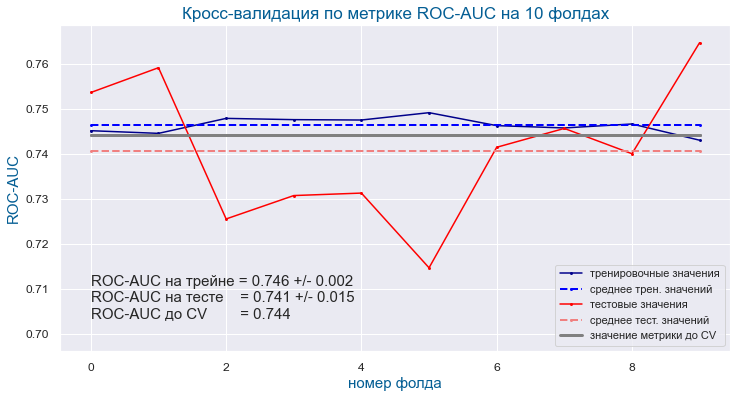

In [141]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
my.vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

### Поиск оптимальных параметров модели

In [142]:
# третья модель
model = LogisticRegression(C=7, 
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=RANDOM_SEED,
                           max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [143]:
my.test_last_pred(y_test, y_pred, y_pred_prob) if (my.last_pred[0].max() == 0) else 0
my.all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.671070,-0.000678,(TP+TN)/(P+N)
balanced accuracy,0.678110,-0.000857,сбалансированная accuracy
precision,0.226715,-0.000606,точность = TP/(TP+FP)
recall,0.687466,-0.001095,полнота = TP/P
f1_score,0.340980,-0.000820,среднее гармоническое точности и полноты
roc_auc,0.744205,0.000057,Area Under Curve - Receiver Operating Characte...


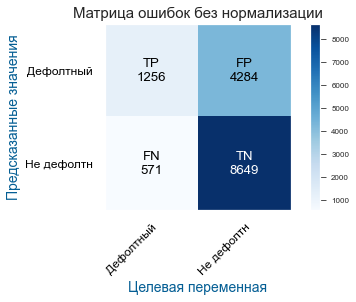

In [144]:
my.confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2, normalize=False)

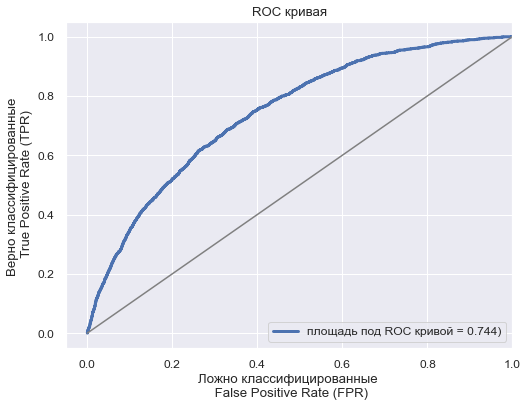

In [145]:
my.ROC_curve_with_area(y_test, y_pred_prob, 1.1)

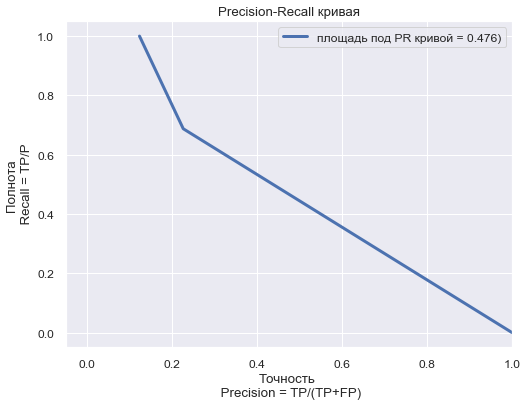

In [146]:
my.PR_curve_with_area(y_test, y_pred, 1.1)

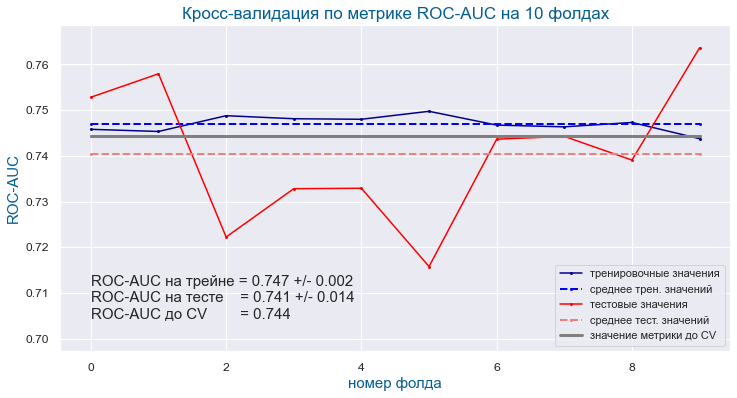

In [147]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
my.vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

## Submission

In [148]:
train_data = df.query('Train == 1').drop(['Train', 'client_id']+drop_list_cols, axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id']+drop_list_cols, axis=1)

In [149]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [150]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 32), (73799, 32), (73799, 31), (73799,), (36349, 31))

In [151]:
model = LogisticRegression(C=7, 
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=RANDOM_SEED,
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=7, class_weight='balanced', max_iter=1000,
                   multi_class='ovr', random_state=42, solver='liblinear')

In [152]:
y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

score - 0.73650  
не хватило времени пересчитать модель с учетом нескольких распеделений в decline_app_cnt и почистить признак income. Вероятно, с учетом этого score будет ниже.